# Creation of molecular embeddings for classifying compounds using Transformers

## Obtaining Data

Get the latest version of the dataset from the repository

In [51]:
import numpy as np
import pandas as pd
import requests
import io

url = 'https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'

data = requests.get(url).content
df = pd.read_csv(io.StringIO(data.decode('utf-8')), index_col = 0)
df.reset_index(inplace=True)
df

smiles activity  HIV_active
0      CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0
1      C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0
2                       CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0
3        Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0
4                                 O=S(=O)(O)CCS(=O)(=O)O       CI           0
...                                                  ...      ...         ...
41122  CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...       CI           0
41123  Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...       CI           0
41124  Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...       CI           0
41125  Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...       CI           0
41126  CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...       CI           0

[41127 rows x 3 columns]

## Pre-Processing Data

Create a vocabulary of tokens based on the SMILES specifications

http://opensmiles.org/opensmiles.html

In [52]:
elements = 'H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,Ar,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,Rf,Db,Sg,Bh,Hs,Mt,Ds,Rg,Cn,Uut,Fl,Uup,Lv,Uus,Uuo'
aromatic_atoms = 'b,c,n,o,p,s,as,se,te'
symbols = '[,],(,),=,+,-,#,:,@,.,%'
isotopes = '0,1,2,3,4,5,6,7,8,9'

elements = str(elements).split(',')
aromatic_atoms = str(aromatic_atoms).split(',')
symbols = str(symbols).split(',')
isotopes = str(isotopes).split(',')

smiles_vocabulary = elements + aromatic_atoms + symbols + isotopes

Method to process a SMILES by spliting it into an array of tokens that are part of the SMILES vocabulary

In [53]:
def process_smiles(smiles, vocabulary):
  tokens = []
  i = 0;
  found = False;
  while i < len(smiles):
    if len(smiles[i:]) >= 3:
      if smiles[i:i+3] in vocabulary:
        tokens.append(smiles[i:i+3])
        i += 3
        found = True
    if len(smiles[i:]) >= 2 and not found:
      if smiles[i:i+2] in vocabulary:
        tokens.append(smiles[i:i+2])
        i += 2
        found = True
    if len(smiles[i:]) >= 1 and not found:
      if smiles[i] in vocabulary:
        tokens.append(smiles[i])
        i += 1
        found = True
    if not found:
      print('Error in value', smiles[i])
      print(smiles)
      break
    found = False
  return tokens

Method to process an array of SMILES into a list of processed SMILES and respective lengths (number of tokens)

In [54]:
def process_smiles_array(smiles_array):
  processed_list = list()
  lengths = list()
  for i in range(len(smiles_array)):
      processed_smiles = process_smiles(smiles_array[i], smiles_vocabulary)
      processed_list.append(' '.join(processed_smiles))
      lengths.append(len(processed_smiles))
  return processed_list, lengths

Process all SMILES in the dataset

In [55]:
processed_smiles, smiles_lengths = process_smiles_array(df['smiles'].values)

Insert processed SMILES and respective lengths into the dataset

In [56]:
df['processed_smiles'] = processed_smiles
df['smiles_length'] = smiles_lengths
df

smiles  ... smiles_length
0      CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...  ...            51
1      C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...  ...            83
2                       CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21  ...            31
3        Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1  ...            47
4                                 O=S(=O)(O)CCS(=O)(=O)O  ...            22
...                                                  ...  ...           ...
41122  CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...  ...            55
41123  Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...  ...            71
41124  Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...  ...            60
41125  Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...  ...            60
41126  CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...  ...            66

[41127 rows x 5 columns]

Plot a histogram with the distribution of the lengths of the SMILES in the dataset

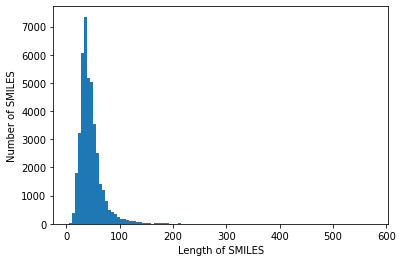

In [57]:
import matplotlib.pyplot as plt

plt.hist(smiles_lengths, bins=100)
plt.ylabel('Number of SMILES')
plt.xlabel('Length of SMILES')
plt.show()

Check the percentage of the instances from the dataset where the length of the SMILES is too small/big

In [58]:
length_range = (15, 125)

filtered = filter(lambda x: length_range[0] <= x <= length_range[1], smiles_lengths)
percentage = len(list(filtered)) / len(processed_smiles)
print('Percentage of instances with SMILES\' length between %s and %s: %s' % (length_range[0], length_range[1], percentage))

sequence_length = length_range[1]

Percentage of instances with SMILES' length between 15 and 125: 0.9813018211880273


Remove instances from the dataset where the length of the SMILES is too small/big

In [59]:
df = df[(df['smiles_length'] >= length_range[0]) & (df['smiles_length'] <= length_range[1])]
df = df.drop('smiles_length', axis='columns')
df

smiles  ...                                   processed_smiles
0      CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...  ...  C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C (...
1      C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...  ...  C ( = C c 1 c c c c c 1 ) C 1 = [ O + ] [ Cu -...
2                       CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21  ...  C C ( = O ) N 1 c 2 c c c c c 2 Sc 2 c 1 c c c...
3        Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1  ...  N c 1 c c c ( C = C c 2 c c c ( N ) c c 2 S ( ...
4                                 O=S(=O)(O)CCS(=O)(=O)O  ...        O = S ( = O ) ( O ) C C S ( = O ) ( = O ) O
...                                                  ...  ...                                                ...
41122  CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...  ...  C C C 1 C C C 2 c 3 c ( [ n H ] c 4 c c c ( C ...
41123  Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...  ...  C c 1 c c c 2 [ n H ] c 3 c ( c 2 c 1 ) C 1 C ...
41124  Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...  ...  C c 1 c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] c ...
41125  Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...  ...  C c 1 c c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] ...
41126  CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...  ...  C C C C C C = C ( c 1 c c ( Cl ) c ( O C ) c (...

[40358 rows x 4 columns]

##  Transformer model to extract embeddings and use them as input to another classifier

Install necessary packages

In [60]:
! pip install transformers

Check if an GPU is being used

In [61]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Initialize model and tokenizer

> The model selected is the BERT cased model since the tokens in the SMILES vocabulary are cased dependent, for example, the token for the chemical element Carbon 'C' must be differentiated from the token for the aromatic element 'c'.  

In [62]:
from transformers import TFAutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Method to handle tokenization

In [63]:
def tokenize(sequence):
    return tokenizer.encode_plus(sequence,                    # sequence to tokenize
                                 max_length=sequence_length,  # maximum length for the sequence
                                 truncation=True,             # truncate any sequence longer than the maximum length
                                 padding='max_length',        # allow any sequence shorter than the maximum length to be padded
                                 add_special_tokens=True,     # allow special tokens (important for BERT)
                                 return_attention_mask=True,  # output attention_mask needed
                                 return_token_type_ids=False, # output token_type_ids not needed 
                                 return_tensors='tf')         # return TensorFlow tensors
    return tokens

Demonstration of BERT's tokenization

In [64]:
processed_smiles = df['processed_smiles'].values

smiles = processed_smiles[0]

input_ids = tokenize(smiles)
ids = input_ids['input_ids'][0].numpy()

print('Sequence of tokens:\n')
print(smiles)
print('\n')

print('List of BERT\'s vocabulary indeces:\n')
print(ids)
print('\n')

print('Decoding of the indeces:\n')
print(tokenizer.decode(ids))

Sequence of tokens:

C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C ( C C ) C 1 ) [ O + ] = C ( C C ) C C ( C C ) = [ O + ] 2


List of BERT's vocabulary indeces:

[ 101  140  140  140  122  134  164  152  116  166  164  140 1358  118
  124  166  123  113  164  152  116  166  134  140  113  140  140  114
  140  122  114  164  152  116  166  134  140  113  140  140  114  140
  140  113  140  140  114  134  164  152  116  166  123  102    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


Decoding of the indeces:

[CLS] C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C ( C C ) C 1 ) [ O + ] = C ( C C ) C C ( C C ) = [ O + ] 2 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Method to generate an embedding for a sequence as a single vector

> The model BERT has 12 hidden states, each being the output of its 12 layers (transformer blocks).

> Each token is represented by a vector with 768 features. This means that each sequence of tokens is represented by an array with the dimensions (length of the sequence, 768). 

> The strategy to generate an embedding from a sequence of tokens is to average, for each token, the values its vector. This means that each sequence of tokens is represented by a one-dimensional vector with 768 features.

In [65]:
def get_embedding(sequence):
  input_ids = tokenize(sequence)              # sequence tokenization
  outputs = model(input_ids)                  # run the sequence through BERT
  last_hidden_state = outputs[0]              # get the last hidden state
  vectors = last_hidden_state[0]              # get the token vectors from the last hidden state
  embedding = tf.reduce_mean(vectors, axis=0) # calculate the average for all token vectors
  return embedding.numpy()

Generate embeddings for all the SMILES in the dataset

In [66]:
from tqdm import tqdm

embeddings = []

#for smiles in tqdm(processed_smiles):
for smiles in tqdm(processed_smiles[0:9]):
  embedding = get_embedding(smiles)
  embeddings.append(embedding)


100%|██████████| 9/9 [00:01<00:00,  8.43it/s]


## References

https://towardsdatascience.com/tensorflow-and-transformers-df6fceaf57cc

https://www.kaggle.com/sameerpixelbot/bert-embeddings-with-tensorflow-2-0-example

https://betterprogramming.pub/build-a-natural-language-classifier-with-bert-and-tensorflow-4770d4442d41

https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca

https://www.sbert.net/examples/applications/computing-embeddings/README.html

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
